# Analyzing replicability of functional connectivity-based multivariate BWAS on the Human Connectome Project dataset

Comprehensive analysis with 52 HCP phenotypes

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
from statsmodels.formula.api import ols as ols_f
from mlconfound.stats import partial_confound_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB or via `get_data.ipynb` (requires credentials).
See [readme.md](readme.md) for more details.

array([[<AxesSubplot: title={'center': 'motion'}>]], dtype=object)

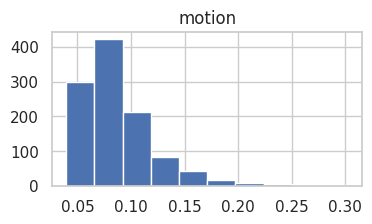

In [2]:
motion = pd.read_csv('hcp_data/motion.csv', index_col=0).set_index('ID', drop=True, inplace=False)
motion.hist()

In [3]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# add motion
behavior = behavior.merge(motion, left_index=True, right_index=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior.describe()

,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,...,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,motion,age
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1092.000000,1089.000000,1093.000000,1088.000000,1088.000000,1087.000000,1084.000000,1084.000000,1094.000000,1094.000000
mean,1.603291,1.520110,3.861974,95.959049,96.945978,98.537477,98.685923,98.533638,95.662431,95.676417,...,97.942894,1.410468,45.704117,95.119991,93.948309,1.846578,0.582103,1.823349,0.088170,28.871572
std,0.489438,0.499824,0.513459,14.799877,11.835880,12.010211,11.262753,12.010414,20.291338,20.293050,...,11.115135,1.734575,7.581136,14.358339,14.614322,0.568080,0.983564,0.569718,0.033718,3.583816
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59.860000,0.000000,38.600000,56.350000,59.500000,1.560000,0.000000,1.080000,0.039544,23.500000
25%,1.000000,1.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,87.110000,0.000000,38.600000,84.070000,83.220000,1.800000,0.000000,1.760000,0.064558,28.000000
50%,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,98.040000,1.000000,45.900000,95.850000,94.990000,1.800000,0.000000,1.800000,0.079880,28.000000
75%,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,110.450000,2.000000,52.200000,104.660000,102.920000,1.880000,1.000000,1.840000,0.101661,33.000000
max,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,111.410000,10.000000,75.300000,134.650000,131.380000,15.000000,17.000000,15.000000,0.302853,36.000000


# Helper function to prepare target variable


In [4]:
def create_data(target='CogTotalComp_AgeAdj', feature_data=netmats_parcor):
    # it's a good practice to use pandas for merging, messing up subject order can be painful
    features = feature_data.columns
    df = behavior
    df = df.merge(feature_data, left_index=True, right_index=True, how='left')

    df = df.dropna(subset = [target] + features.values.tolist())
    y = df[target].values
    X = df[features].values
    return X, y, df.motion.values

# Helper function implementing a single bootstrap iteration

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

In [5]:
def corr(X, Y):
    # just a small wrapper function (pandas correlation is silent in "unlucky" bootstraps with constant values)
    return pd.Series(X).corr( pd.Series(Y))

def bootstrap_workhorse(X, y, fd, sample_size, model, random_state, shuffle_y=False):

    #create discovery and replication samples by random sampling from the whole dataset (without replacement)

    # if shuffle_y is true, a null model is created bz permuting y
    if shuffle_y:
        rng = np.random.default_rng(random_state)
        y = rng.permutation(y)

    # sample the discovery and replication sets *without replacement* (with replacement introduces spurious dependencies)
    std = 0
    rs = random_state
    while std == 0 or np.isnan(std):
        X_discovery, X_replication, y_discovery, y_replication, fd_discovery, fd_replication = train_test_split(X, y, fd, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=rs)
        std = np.std(y_discovery) * np.std(y_replication)
        rs = rs + 1

    # standard 10-fold cross-validation
    cv = KFold(10)

    # below we obtain cross-validated predictions in the discovery sample
    predicted_discovery_cv = np.zeros_like(y_discovery)  # here we collect the predictions for each fold
    cor_per_fold = np.zeros(cv.n_splits)  # here we collect the predictive performance in each fold
    i = 0  # just a counter
    for train, test in cv.split(X=X_discovery, y=y_discovery):  # loop to leave one fold out

        # regress out fd from the target and predict fd-orthogonal target in the test phase
        tmp = pd.DataFrame({
                'y': y_discovery,
                'fd': fd_discovery
            })
        OLS_model = ols_f("y ~ fd", tmp.iloc[train]).fit()
        y_discovery[train] = OLS_model.resid
        y_discovery[test] = y_discovery[test] - OLS_model.predict(tmp.iloc[test])

        model.fit(X=X_discovery[train], y=y_discovery[train]) # fit model to the training set
        predicted_discovery_cv[test] = model.predict(X=X_discovery[test]) # use fitted model to predict teh test set
        cor_per_fold[i] = corr(y_discovery[test], predicted_discovery_cv[test]) # calculate performance on tne test set
        i += 1
    # calculate mean test performance across all folds
    r_disc_cv = np.mean(cor_per_fold)
    # 'finalize' model by training it on the full discovery sample (without cross-validation)
    final_model = model.fit(X=X_discovery, y=y_discovery)
    # obtain predictions with the final model on the discovery sample, note that this model actually overfits this sample.
    # we do this only to demonstrate biased estimates
    predicted_discovery_overfit = final_model.predict(X=X_discovery)
    # here we obtain the biased effect size (r) estimates for demonstrational purposes
    r_disc_overfit = corr(predicted_discovery_overfit, y_discovery)

    # We use the final model to predict the replication sample
    # This is correct (no overfitting here), the final model did not see this data during training
    predicted_replication = final_model.predict(X=X_replication)
    # we obtain the out-of-sample prediction performance estimates
    tmp = pd.DataFrame({
                'y': y_replication,
                'fd': fd_replication
            })
    OLS_model = ols_f("y ~ fd", tmp).fit()
    y_replication_orig = y_replication
    y_replication = OLS_model.resid
    r_rep = corr(predicted_replication, y_replication)

    # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
    # (one sided tests, testing for positive correlation)
    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)
    p_disc_overfit = permutation_test(predicted_discovery_overfit, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)

    # here we calculate motion bias p-value in the replication sample
    p_bias = partial_confound_test(y=y_replication_orig, yhat=predicted_replication, c=fd_replication, random_state=random_state, progress=False).p

    return r_disc_cv, r_disc_overfit, r_rep, p_disc_cv, p_disc_overfit, p_rep, p_bias

All set, now we start the analysis.

# Replicability with sample sizes n=50, 100, 200, 300 and max
Here we train a few different models on 100 bootstrap samples.

We aggregate the results of our workhorse function in `n_bootstrap`=100 bootstrap cases (run in parallel).

The whole process is repeated for all sample sizes, fetaure_sets and target variables.

## Here we test all 33 variables, proposed by Marek et al. in their response.

In [6]:
targets = [
#demographics
    'age',
# cognition
    'MMSE_Score',
    'PSQI_Score',
    'PicSeq_AgeAdj',
    'CardSort_AgeAdj',
    'Flanker_AgeAdj',
    'PMAT24_A_CR',
    'CogFluidComp_AgeAdj',
    'CogCrystalComp_AgeAdj',
    'CogEarlyComp_AgeAdj',
    'CogTotalComp_AgeAdj',
    'ReadEng_AgeAdj',
    'PicVocab_AgeAdj',
    'ProcSpeed_AgeAdj',
    'DDisc_AUC_200',
    'VSPLOT_TC',
    'SCPT_SEN',
    'SCPT_SPEC',
# memory
    'IWRD_TOT',
    'ListSort_AgeAdj',
# emotion
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    'PercStress_Unadj',
    'SelfEff_Unadj',
    'Dexterity_AgeAdj',
 # personality
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E',
# sensory
    'Noise_Comp',
    'Odor_AgeAdj',
    'PainInterf_Tscore',
    'Taste_AgeAdj',
    'Mars_Final'
]

# Now we fit a simple Ridge regression
(no feature selection, no hyperparameter optimization)

In [7]:
%%capture
%%time
random_state = 42
n_bootstrap = 100

features = {
    'netmats_parcor': netmats_parcor#,
    #'netmats_pearson': netmats_pearson
}

models = {
    'ridge': Ridge()
}

# We aggregate all results here:
df = pd.DataFrame(columns=['connectivity','model','target','n','r_discovery_cv','r_discovery_overfit','r_replication','p_discovery_cv','p_discovery_overfit','p_replication', 'p_bias'])

for feature_set in features:
    for model in models:
        for target_var in targets:
            for sample_size in ['max']:

                print('*****************************************************************')
                print(feature_set, model, target_var, sample_size)

                X, y, fd = create_data(target=target_var, feature_data=features[feature_set])

                if sample_size=='max':
                    sample_size = int(len(y)/2)

                # create random seeds for each bootstrap iteration for reproducibility
                rng = np.random.default_rng(random_state)
                random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

                # run bootstrap iterations in parallel
                r_discovery_cv, r_discovery_overfit, r_replication, p_discovery_cv, p_discovery_overfit, p_replication, p_bias = zip(
                    *Parallel(n_jobs=1)(
                    delayed(bootstrap_workhorse)(X.copy(), y.copy(), fd.copy(), sample_size, models[model], seed) for seed in random_sates))

                tmp_data_frame = pd.DataFrame({
                    'connectivity' : feature_set,
                    'model' : model,
                    'target' : target_var,
                    'n' : sample_size,
                    'r_discovery_cv': r_discovery_cv,
                    'r_discovery_overfit': r_discovery_overfit,
                    'r_replication': r_replication,
                    'p_discovery_cv': p_discovery_cv,
                    'p_discovery_overfit': p_discovery_overfit,
                    'p_replication': p_replication,
                    'p_bias': p_bias
                })
                #sns.scatterplot(x='r_replication', y='r_discovery_cv', data=tmp_data_frame)
                #plt.ylabel('in-sample (r)')
                #plt.xlabel('out-of-sample (r_pred)')
                #plt.show()
                print('r discovery (with cv) :', tmp_data_frame.r_discovery_cv.mean(), 'r replication:', tmp_data_frame.r_replication.mean())

                for alpha in [0.05]:
                    print('Replicability at alpha =', alpha, ':',
                          (tmp_data_frame.loc[tmp_data_frame['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (tmp_data_frame['p_discovery_cv']<0.05).sum() * 100, '%')
                print("Motion bias:", tmp_data_frame.p_bias.mean(), tmp_data_frame.p_bias.std())

                df = pd.concat((df, tmp_data_frame))
                df.reset_index(drop=True, inplace=True)
                df.to_csv('res/revised_results_Ridge_fd.csv')

df


/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encount

In [8]:
df.groupby(['connectivity', 'model', 'target', 'n']).mean()[['r_discovery_cv', 'r_replication', 'p_bias']]

r_discovery_cv  r_replication  \
connectivity   model target                n                                    
netmats_parcor ridge AngAffect_Unadj       500        0.083911       0.097523   
                     AngAggr_Unadj         500        0.174860       0.178205   
                     AngHostil_Unadj       500        0.065354       0.066244   
                     CardSort_AgeAdj       499        0.168875       0.174110   
                     CogCrystalComp_AgeAdj 498        0.478393       0.488006   
                     CogEarlyComp_AgeAdj   496        0.318284       0.314487   
                     CogFluidComp_AgeAdj   495        0.286584       0.281001   
                     CogTotalComp_AgeAdj   494        0.440612       0.444544   
                     DDisc_AUC_200         499        0.181074       0.178266   
                     Dexterity_AgeAdj      500        0.148792       0.150019   
                     ER40ANG               499        0.065080       0.072857   
                     ER40FEAR              499        0.036240       0.029427   
                     ER40HAP               499       -0.040475      -0.040974   
                     ER40NOE               499        0.046832       0.054712   
                     ER40SAD               499        0.028999       0.033857   
                     EmotSupp_Unadj        500        0.124379       0.113373   
                     FearAffect_Unadj      500        0.142047       0.153561   
                     FearSomat_Unadj       500        0.053006       0.042376   
                     Flanker_AgeAdj        500        0.124328       0.133105   
                     Friendship_Unadj      500        0.088484       0.083519   
                     IWRD_TOT              499        0.062716       0.056784   
                     InstruSupp_Unadj      500        0.036281       0.032797   
                     LifeSatisf_Unadj      500        0.183808       0.184778   
                     ListSort_AgeAdj       500        0.261719       0.276666   
                     Loneliness_Unadj      500        0.098174       0.100536   
                     MMSE_Score            500             NaN            NaN   
                     Mars_Final            498        0.061327       0.026108   
                     MeanPurp_Unadj        500        0.092541       0.095710   
                     NEOFAC_A              499        0.170426       0.180072   
                     NEOFAC_C              499        0.183556       0.195523   
                     NEOFAC_E              499        0.157592       0.169936   
                     NEOFAC_N              499        0.067182       0.079192   
                     NEOFAC_O              499        0.252453       0.265905   
                     Noise_Comp            497        0.134067       0.123952   
                     Odor_AgeAdj           499        0.022999       0.024210   
                     PMAT24_A_CR           498        0.273698       0.270505   
                     PSQI_Score            500             NaN       0.080488   
                     PainInterf_Tscore     500        0.021068       0.028892   
                     PercHostil_Unadj      500        0.045781       0.036761   
                     PercReject_Unadj      500        0.037067       0.037709   
                     PercStress_Unadj      500        0.089891       0.097533   
                     PicSeq_AgeAdj         500        0.166367       0.167290   
                     PicVocab_AgeAdj       500        0.449331       0.446806   
                     PosAffect_Unadj       500        0.084311       0.095997   
                     ProcSpeed_AgeAdj      500        0.111175       0.120839   
                     ReadEng_AgeAdj        500        0.421093       0.430223   
                     SCPT_SEN              499        0.002666       0.002837   
                     SCPT_SPEC             499        0.135545       0.141939  

/tmp/ipykernel_219850/1914091046.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_219850/1914091046.py:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



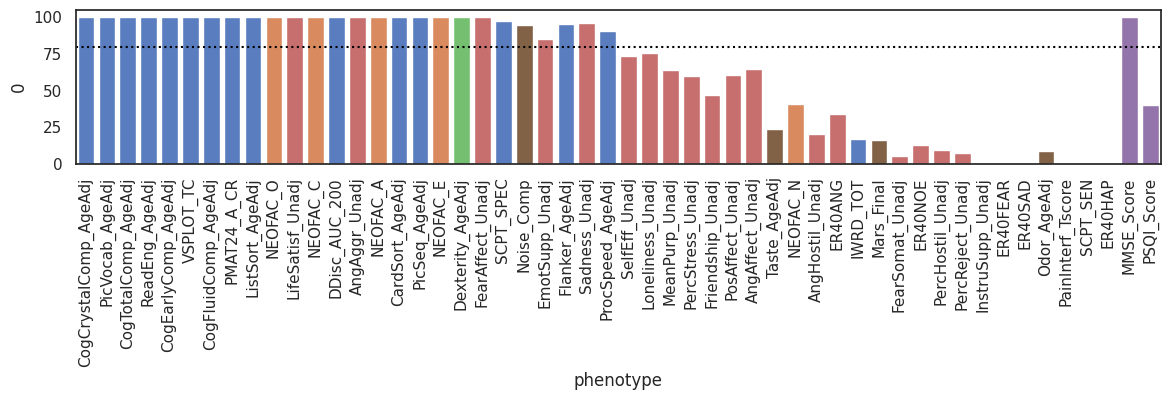

In [27]:
sns.set(rc={"figure.figsize":(14, 2)})
sns.set_style("white")

phenotypes = pd.read_csv('hcp_data/phenotypes-of-interest.csv').iloc[:, 1:]
phenotypes = phenotypes.drop([2,3]) # Age duplicates

def prep(x, alpha=0.05):
    return (x.loc[x['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (x['p_discovery_cv']<0.05).sum() * 100

df_plot = pd.DataFrame(df[df.connectivity=='netmats_parcor'].groupby('target').apply(prep))

df_plot['r_discovery'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['r_discovery_cv']
df_plot['p_bias'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['p_bias']
df_plot = df_plot[df_plot.index!='age']                       
                       
df_plot['category'] = ''
df_plot['phenotype'] = df_plot.index

for i in df_plot.index:
    df_plot.loc[i, 'category'] = phenotypes.loc[phenotypes.columnHeader==i, 'category'].values[0]

                       
df_plot = df_plot.sort_values(by='r_discovery', ascending=False)                      
                       
pal = "muted"
my_colormap = [
              sns.color_palette(pal)[4],
              sns.color_palette(pal)[0], # cognition
              sns.color_palette(pal)[3], # emotion
              sns.color_palette(pal)[2], # dexterity
              sns.color_palette(pal)[1], # big5
              sns.color_palette(pal)[5], # sensory
              sns.color_palette(pal)[6], # ?
              sns.color_palette(pal)[3]]
colors = []
for code in pd.Categorical(df_plot.category).codes:
    colors.append(my_colormap[code])

ax=sns.barplot(data=df_plot, x='phenotype', y=0, palette=colors)
plt.xticks(rotation=90)
ax.axhline(80, color='black', linestyle=':')
plt.savefig('fig/replicability_all_phenotypes_fd.pdf')

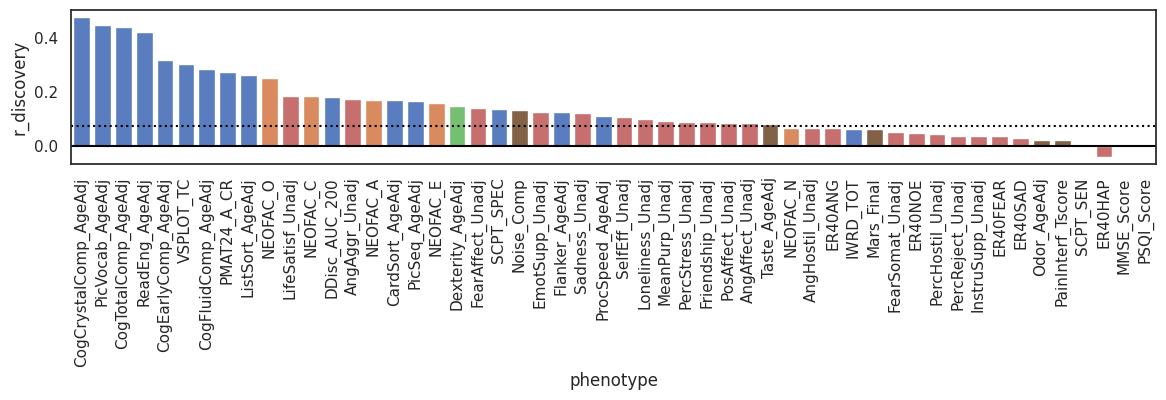

In [28]:
ax=sns.barplot(data=df_plot, x='phenotype', y='r_discovery', palette=colors)
plt.xticks(rotation=90)
ax.axhline(0.074, color='black', linestyle=':') # parametric one-sided significance threshold
ax.axhline(0, color='black')
plt.savefig('fig/r_discovery_all_phenotypes_fd.pdf')

In [31]:
for i in df_plot.index:
    df_plot.loc[i, 'phenotype_long'] = phenotypes.loc[phenotypes.columnHeader==i, 'fullDisplayName'].values[0]
df_plot

,0,r_discovery,p_bias,category,phenotype,phenotype_long
target,,,,,,
CogCrystalComp_AgeAdj,100.000000,0.478393,0.61958,Cognition,CogCrystalComp_AgeAdj,NIH Toolbox Cognition Crystallized Composite: ...
PicVocab_AgeAdj,100.000000,0.449331,0.46671,Cognition,PicVocab_AgeAdj,NIH Toolbox Picture Vocabulary Test: Age-Adjus...
CogTotalComp_AgeAdj,100.000000,0.440612,0.58473,Cognition,CogTotalComp_AgeAdj,NIH Toolbox Cognition Total Composite Score: A...
ReadEng_AgeAdj,100.000000,0.421093,0.56276,Cognition,ReadEng_AgeAdj,NIH Toolbox Oral Reading Recognition Test: Age...
CogEarlyComp_AgeAdj,100.000000,0.318284,0.40190,Cognition,CogEarlyComp_AgeAdj,NIH Toolbox Cognition Early Childhood Composit...
VSPLOT_TC,100.000000,0.304904,0.40537,Cognition,VSPLOT_TC,Variable Short Penn Line Orientation: Total Nu...
CogFluidComp_AgeAdj,100.000000,0.286584,0.47973,Cognition,CogFluidComp_AgeAdj,NIH Toolbox Cognition Fluid Composite: Age Adj...
PMAT24_A_CR,100.000000,0.273698,0.45357,Cognition,PMAT24_A_CR,Penn Progressive Matrices: Number of Correct R...
ListSort_AgeAdj,100.000000,0.261719,0.48862,Cognition,ListSort_AgeAdj,NIH Toolbox List Sorting Working Memory Test: ...


In [53]:
df_plot.loc[:, 'phenotype'] = ['CogCrystal', 'PicVocab', 'CogTotal',
 'ReadEng', 'CogEarly', 'Visuospat', 'CogFluid',
 'FluidIQ', 'ListSort', 'DelayDisc', 'CardSort',
 'PicSeqMem', 'ContPerfSpec', 'Flanker', 'ProcSpeed',
 'WordMem', 'ContPerfSen', 'Open', 'Conscient', 'Agreeable', 'Extrovert',
 'Neurotic', 'MentalStatus', 'Sleep', 'Dexterity', 'NoiseComp',
 'Taste', 'ContrastSens', 'Odor', 'PainInterf',
 'LifeSatisf', 'AngerAggr', 'FearAffect', 'EmotSupp',
 'Sadness', 'SelfEff', 'Loneliness', 'MeaningPurp',
 'PercStress', 'Friendship', 'PosAffect', 'AngerAffect',
 'AngerHost', 'AngerRec', 'FearSomat', 'NeutralRec',
 'PercHost', 'PercReject', 'InstruSupp', 'FearRec',
 'SadRec', 'HappyRec']

df_plot.drop('MMSE_Score', inplace=True) # nan because of not enough levels for bootstrapping

In [54]:
import plotly.express as px

fig = px.bar(df_plot, y=0, x='phenotype', text_auto='.2s',
            title="Replication probability with n=500",
            labels={'0':'$P_{rep}$'},
            hover_data=['category', 'phenotype_long', 'r_discovery', 'p_bias'], color='category')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()



In [61]:
import plotly
import plotly.graph_objs as go

colors = ["#de324c","#f4895f","#f8e16f","#95cf92","#9656a2","#369acc"]

cols = [ colors[c] for c in pd.Categorical(df_plot['category']).codes]

df_plot['category'] = pd.Categorical(df_plot['category'])
df_plot['category'].cat.reorder_categories(['Emotion', 'Sensory',  'Motor', 'Alertness', 'Personality',  'Cognition'], inplace= True)
df_plot = df_plot.sort_values(by=['category', 'r_discovery'], ascending=False)

trace1l = go.Scatter( name='',
            x=df_plot['phenotype'].values,
            y=[80] * len(df_plot['phenotype'].values),
            mode='lines',
            line = dict(color='gray', width=1, dash='dash'),
            showlegend=False,
            hovertemplate="Replication threshold"
        )

trace1 = go.Bar(x=df_plot['phenotype'].values,y=df_plot[0].values, name='',
                marker_color=cols, showlegend=False,
                customdata=df_plot.values,
                #texttemplate="%{y:0.0f}%",
                textposition="outside",
                textangle=0,
                textfont_color="gray",
                hovertemplate="<br>".join([
                    "Domain: %{customdata[3]}",
                    "Effect Size: r=%{customdata[1]:.2f}",
                    "Replication Probability: %{customdata[0]:.0f}%",
                    "Motion bias: p=%{customdata[2]}",
                    "Description: %{customdata[5]}"
                ])
                #hovertext=pd.Categorical(df_plot['category'])
                )

trace2l = go.Scatter( name='',
            x=df_plot['phenotype'].values,
            y=[0.074] * len(df_plot['phenotype'].values),
            mode='lines',
            line = dict(color='gray', width=1, dash='dash'),
            showlegend=False,
            hovertemplate="Significance threshold",
            visible=False
        )


trace2 = go.Bar(x=df_plot['phenotype'].values,y=df_plot['r_discovery'], visible=False, name='',
                marker_color=cols, showlegend=False,
                customdata=df_plot.values,
                #texttemplate="%{y:0.2f}",
                textposition="outside",
                textangle=0,
                textfont_color="gray",
                hovertemplate="<br>".join([
                    "Domain: %{customdata[3]}",
                    "Effect Size: r=%{customdata[1]:.2f}",
                    "Replication Probability: %{customdata[0]:.0f}%",
                    "Motion bias: p=%{customdata[2]}",
                    "Description: %{customdata[5]}"
                ])
                )
data = [trace1l, trace1, trace2l, trace2]

updatemenus = list([
    dict(active=0,
         showactive = True,
         buttons=list([
            dict(label = "Replication Probability",
                 method = "update",
                 args = [{"visible": [True, True, False, False]}]), # hide trace2
            dict(label = "Predictive Effect Size",
                 method = "update",
                 args = [{"visible": [False, False, True, True]}]) # hide trace1
            ]),
         x = 0,
         xanchor = 'left',
         y = 1.5,
         yanchor = 'top',
         )])

layout = dict(title="",
              showlegend=True,
              xaxis=dict(title="Phenotype",
                        showgrid=False, # thin lines in the background
                        #showticklabels=False,  # numbers below),
                        zeroline=True # thick line at x=0
                         ),
              updatemenus=updatemenus,
              template='simple_white',
              font=dict(
                size=10,
                color="gray"),
              autosize=True,
              height=280,
              margin=dict(
              l=5,
              r=5,
              b=10,
              t=10,
              pad=4
    ),
    )

fig=dict(data=data, layout=layout)

#plotly.offline.plot(fig)
#go.Figure(fig).show()
import plotly.io as pio
pio.write_html(fig, file='docs/_includes/figure_fd.html', auto_open=True)

/tmp/ipykernel_219850/1220639146.py:9: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.



In [32]:
df_plot

,0,r_discovery,p_bias,category,phenotype,phenotype_long
target,,,,,,
CogCrystalComp_AgeAdj,100.000000,0.478393,0.61958,Cognition,CogCrystalComp_AgeAdj,NIH Toolbox Cognition Crystallized Composite: ...
PicVocab_AgeAdj,100.000000,0.449331,0.46671,Cognition,PicVocab_AgeAdj,NIH Toolbox Picture Vocabulary Test: Age-Adjus...
CogTotalComp_AgeAdj,100.000000,0.440612,0.58473,Cognition,CogTotalComp_AgeAdj,NIH Toolbox Cognition Total Composite Score: A...
ReadEng_AgeAdj,100.000000,0.421093,0.56276,Cognition,ReadEng_AgeAdj,NIH Toolbox Oral Reading Recognition Test: Age...
CogEarlyComp_AgeAdj,100.000000,0.318284,0.40190,Cognition,CogEarlyComp_AgeAdj,NIH Toolbox Cognition Early Childhood Composit...
VSPLOT_TC,100.000000,0.304904,0.40537,Cognition,VSPLOT_TC,Variable Short Penn Line Orientation: Total Nu...
CogFluidComp_AgeAdj,100.000000,0.286584,0.47973,Cognition,CogFluidComp_AgeAdj,NIH Toolbox Cognition Fluid Composite: Age Adj...
PMAT24_A_CR,100.000000,0.273698,0.45357,Cognition,PMAT24_A_CR,Penn Progressive Matrices: Number of Correct R...
ListSort_AgeAdj,100.000000,0.261719,0.48862,Cognition,ListSort_AgeAdj,NIH Toolbox List Sorting Working Memory Test: ...


In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Replicable", "Not Replicable"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[15+4+0+1+1, 2+1+1+0+3], name="Trait-like",  marker_colors=['green', 'red'], rotation=-90),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[5, 18], name="State-like", rotation=90),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent+name")

fig.update_layout(
    template='simple_white',
    title_text="",
    font=dict(
                size=10,
                color="gray"),
    autosize=True,
    height=70,
    width=500,
    margin=dict(
              l=5,
              r=5,
              b=10,
              t=10,
              pad=4),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=-0.4,
        font_color='black'
    ),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Trait-like', x=-0.02, y=1.1, font_size=12, font_color='black', showarrow=False),
                 dict(text='State-like', x=0.7, y=1.1, font_size=12, font_color='black', showarrow=False)])
fig.show()
import plotly.io as pio
pio.write_html(fig, file='docs/_includes/pie_fd.html', auto_open=False)